---
title: "4. BERT"
image: "disaster.jpeg"
author: "Diegulio"
format: 
  html:
    code-fold: false
jupyter: python3
---

# 4. BERT (Bidirectional Encoder Representations from Transformers)

As we see in the previous notebook, RNN improve the results and give us some benefits. But they are expensive to train, mainly because they are not paralellizable! Now we are in the transformers era. Transformers are models that leverage the mechanism of **self-attention**.

In this specific case we will apply BERT. I will let you with some references that help me to understand what is happend behind scenes:

- http://nlp.seas.harvard.edu/annotated-transformer/
- http://jalammar.github.io/illustrated-transformer/
- https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
- https://www.youtube.com/watch?v=xI0HHN5XKDo&t=2s&pp=ugMICgJlcxABGAE%3D
- https://www.youtube.com/watch?v=7kLi8u2dJz0
- https://www.youtube.com/watch?v=TQQlZhbC5ps&list=PLTl9hO2Oobd_bzXUpzKMKA3liq2kj6LfE&index=1


> Remember that this belong to a NLP Notebook series where I am learning and testing different NLP approachs in this competition. Like NN, Embedding, RNN, Transformers, HuggingFace, etc.

> To see the other notebooks visit: https://www.kaggle.com/code/diegomachado/seqclass-nn-embed-rnn-lstm-gru-bert-hf

# Libraries

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.8.4 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.28.0 which is incompatible.
pytorch-lightning 1.7.7 requires tensorboard>=2.9.1, but you have tensorboard 2.8.0 which is incompatible

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import gc


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Lambda
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import tensorflow_hub as hub
import tensorflow_text as text # Bert preprocess uses this 
from tensorflow.keras.optimizers import Adam

import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors

#nltk.download('stopwords')

# Data

Due to BERT model could consume a lot of ram. This time we will read our data directly from the disc and so feed it to the model!

For this we will use Tensorflow datasets function [`make_csv_dataset`](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset)

In [3]:
train_file_path = "../input/df-split/df_split/df_train.csv"
val_file_path = "../input/df-split/df_split/df_test.csv"

In [4]:
train_ds = tf.data.experimental.make_csv_dataset(
    train_file_path,
    batch_size=32, # Artificially small to make examples easier to show.
    label_name='target',
    select_columns=["text","target"],
    num_epochs=1, # Not repeat the dataset
    ignore_errors=True,)


test_ds = tf.data.experimental.make_csv_dataset(
    val_file_path,
    batch_size=32, # Artificially small to make examples easier to show.
    label_name='target',
    select_columns=["text","target"],
    num_epochs=1, # Not repeat the dataset
    ignore_errors=True,)



In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

👀 Note that we don't need to batch because we did it when we call make_csv_dataset function

# BERT 

Due to BERT is a pretrained encoder model. It was trained in a specific way with an specific preprocessing (See the references above). So it needs its own pre-processing. Luckily, we could Download both the model and the preprocessing pipeline from [Tensorflow Hub](https://www.tensorflow.org/hub).

To see more examples using Tensorflow and BERT visit : https://www.tensorflow.org/text/tutorials/classify_text_with_bert

Before, lets explore a little bit what about BERT in Tensorflow Hub

In [6]:
# Different transformers arquitectures with their preprocessing pipelines in TFHub

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


In [7]:
# Choose one model
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

tfhub_handle_encoder = map_name_to_handle[bert_model_name] # Encoder
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name] # Preprocess

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
# Download preprocess from TFHub
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
# Lets explore preprocessing one train dataset sample 
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
sample = train_df.sample(1).text
processed_sample = bert_preprocess_model(sample)
del train_df
gc.collect()

0

In [10]:
print(sample)
print("=================")
print(processed_sample)

1345    Burning buildings? Media outrage? http://t.co/...
Name: text, dtype: object
{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  5255,  3121,  1029,  2865, 19006,  1029,  8299,  1024,
         1013,  1013,  1056,  1012,  2522,  1013, 13569,  2595,  2480,
         2078,  2615,  2487,  6038,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

Look that our preprocess pipeline outputs 3 tensors:

In [11]:
processed_sample.keys()

dict_keys(['input_type_ids', 'input_word_ids', 'input_mask'])

**Input Ids:** Maybe the most important is the integer encoding (from token to id)

In [12]:
# Integer Embedding by BERT vocabulary
processed_sample["input_word_ids"]
# note:
# 101 : CLS
# 102: SEP

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  5255,  3121,  1029,  2865, 19006,  1029,  8299,  1024,
         1013,  1013,  1056,  1012,  2522,  1013, 13569,  2595,  2480,
         2078,  2615,  2487,  6038,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

**Mask**: To tell bert whats inputs take care of.
This is usefull to tell BERT that we should not take care of padding tokens


In [13]:
processed_sample["input_mask"]

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

We will not use input_type_ids. Though this is necessary because one of the task which BERT was trained was predict next sentence (For this the input was two sentences) so input_type_ids helps BERT to distinguis between sentence. As we now only have one sentence, it is the same to each token. Please see the references to understand more about it.

**Now we will do one pass trough BERT**

In [14]:
# One pass trough bert 
bert_layer = hub.KerasLayer(tfhub_handle_encoder)
sample_result = bert_layer(processed_sample)

In [15]:
sample_result.keys()

dict_keys(['encoder_outputs', 'default', 'sequence_output', 'pooled_output'])

We note that there is some outputs. Here is a summary of them:

- `pooled_output` represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire twitt.
- `sequence_output` represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the twitt.
- `encoder_outputs` are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

# Model

Now we will apply a functional arquitecture model (Instead of sequential as the preovious notebooks)

In [16]:
def bert_model():
    text_input = layers.Input(shape=(), dtype=tf.string, name = "text")
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name = 'preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    bert_outputs = encoder_layer(encoder_inputs)
    net = bert_outputs['pooled_output'] # We will use the pooled_output
    net = tf.keras.layers.Dropout(0.1)(net)
    #net = tf.keras.layers.Dense(16, activation="relu", name='dense')(net)
    #net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='output')(net)
    return tf.keras.Model(text_input, net)

model = bert_model()

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

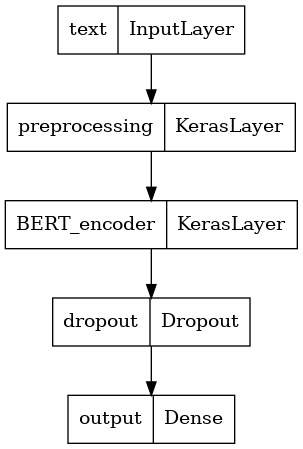

In [18]:
plot_model(model)

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

🚀🚀🚀🚀 **To be faster, we will use GPU in this notebook!**

In [20]:
early_stop_callback = EarlyStopping(patience = 5)
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs,
    callbacks = [early_stop_callback]
)


Epoch 1/100
191/191 [==============================] - 135s 627ms/step - loss: 0.4655 - binary_accuracy: 0.7924 - val_loss: 0.4008 - val_binary_accuracy: 0.8286
Epoch 2/100
191/191 [==============================] - 118s 619ms/step - loss: 0.3522 - binary_accuracy: 0.8571 - val_loss: 0.4128 - val_binary_accuracy: 0.8339
Epoch 3/100
191/191 [==============================] - 118s 621ms/step - loss: 0.2911 - binary_accuracy: 0.8880 - val_loss: 0.4430 - val_binary_accuracy: 0.8293
Epoch 4/100
191/191 [==============================] - 119s 622ms/step - loss: 0.2310 - binary_accuracy: 0.9169 - val_loss: 0.4897 - val_binary_accuracy: 0.8221
Epoch 5/100
191/191 [==============================] - 119s 620ms/step - loss: 0.1832 - binary_accuracy: 0.9355 - val_loss: 0.5471 - val_binary_accuracy: 0.8102
Epoch 6/100
191/191 [==============================] - 118s 620ms/step - loss: 0.1458 - binary_accuracy: 0.9511 - val_loss: 0.6148 - val_binary_accuracy: 0.8155


# Predict Test

In [21]:
test_df = pd.read_csv("../input/nlp-getting-started/test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [22]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
preds = model.predict(topred_ds)

In [24]:
# Now we not apply sigmoid function here because or activation function
test_df["target"] = tf.round(preds)
test_df["target"] = test_df["target"].astype(int)

In [25]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [26]:
#sub.to_csv("BERT_submission.csv", index = False)
sub.to_csv("submission.csv", index = False)

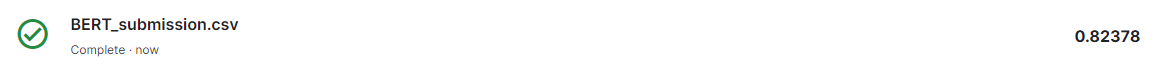

# Observations

🎉🎉🎉🎉🎉🎉 🥳🥳🥳🥳🥳🥳

Wow! We improve our score in more than 2%! So we could see the benefits of use transformers! 

There is a lot of pre-trained models. We could try other types. Now we will use HuggingFace🤗 to apply transformers models.


# 4.2 HuggingFace 🤗

It is a framework to easily develop machine learning models and become well known due to their transformers aplications!

To know more about visit : https://huggingface.co. I encourage you do the course in their website!

In [27]:
# Imports 
from transformers import pipeline

## HF 🤗 Pipelines - Zero Shot Classification

As you can see in the hf documentation. HuggingFace has pipelines, where we can develop a variety of nlp (and more) applications! (Text generation, classification, summarization, etc)

Now we will do [Zero shot classification](https://en.wikipedia.org/wiki/Zero-shot_learning). That means that we will predict classes that wasn't observe during traning. It is a difficult task

In [28]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [29]:
# predict
candidate_labels = ['disaster']
test_df['target'] = [x['scores'][0] for x in classifier(test_df.text.to_list(), candidate_labels)]

In [30]:
test_df["target"] = tf.round(test_df.target)
test_df["target"] = test_df["target"].astype(int)

In [31]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [32]:
sub.to_csv("HF_ZS_Submission.csv", index = False)

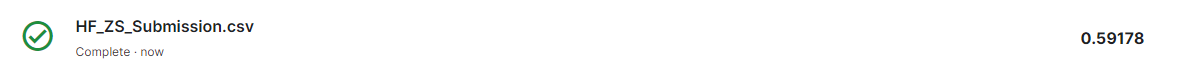

Make sense because is a zero shot classification!

## Fine-Tune

Now we will download a model from HuggingFace models and finetune with our data

In [33]:
# Model name to fine tune
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

In [34]:
from transformers import AutoTokenizer

# First we need to use the tokenizer (Is similar we did in the Tensorflow hub with the preprocessing layer)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    return tokenizer(data["text"])

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [35]:
# We need to load our data, for this we use HF datasets (read directly from the disk, so save us ram)
from datasets import load_dataset
data_files = {"train": "/kaggle/input/df-split/df_split/df_train.csv",
             "test":"/kaggle/input/df-split/df_split/df_test.csv"}
dataset = load_dataset("csv", data_files = data_files, usecols = ['text', 'target'])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1860883215d5579d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'target'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'target'],
        num_rows: 1523
    })
})

In [37]:
# preprocess
dataset = dataset.map(tokenize_dataset)

  0%|          | 0/6090 [00:00<?, ?ex/s]

  0%|          | 0/1523 [00:00<?, ?ex/s]

In [38]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [39]:
# we transform the HF dataset into TF dataset to fine tune
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["target"],
    batch_size=16,
    collate_fn=data_collator,
    shuffle=True)

tf_val_dataset = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["target"],
    batch_size=16,
    collate_fn=data_collator,
    shuffle=True
    )

## Model

In [40]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

# Load and compile our model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
# Lower learning rates are often better for fine-tuning transformers
model.compile(optimizer=Adam(3e-5),metrics = ['accuracy'])


early_stop_callback = EarlyStopping(patience = 5)
model.fit(tf_train_dataset,
         validation_data = tf_val_dataset,
          epochs = 20,
          callbacks = [early_stop_callback]
         )

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

2022-12-12 03:54:13.603300: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-

Epoch 1/20
380/380 [==============================] - 44s 87ms/step - loss: 0.4815 - accuracy: 0.7913 - val_loss: 0.3999 - val_accuracy: 0.8270
Epoch 2/20
380/380 [==============================] - 31s 83ms/step - loss: 0.3179 - accuracy: 0.8750 - val_loss: 0.4339 - val_accuracy: 0.8164
Epoch 3/20
380/380 [==============================] - 31s 83ms/step - loss: 0.2035 - accuracy: 0.9238 - val_loss: 0.4884 - val_accuracy: 0.8053
Epoch 4/20
380/380 [==============================] - 31s 83ms/step - loss: 0.1147 - accuracy: 0.9572 - val_loss: 0.5929 - val_accuracy: 0.7967
Epoch 5/20
380/380 [==============================] - 32s 83ms/step - loss: 0.0829 - accuracy: 0.9729 - val_loss: 0.7295 - val_accuracy: 0.7717
Epoch 6/20
380/380 [==============================] - 31s 82ms/step - loss: 0.0579 - accuracy: 0.9760 - val_loss: 0.9569 - val_accuracy: 0.7855


### Predict Test

In [41]:
pred_dataset = load_dataset("csv", data_files = "/kaggle/input/nlp-getting-started/test.csv", usecols = ['text'])

Extracting data files:   0%|          | 0/1 [00:08<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e12e02ba714b9048/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
# preprocess
pred_dataset = pred_dataset.map(tokenize_dataset)

  0%|          | 0/3263 [00:00<?, ?ex/s]

In [43]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
tf_pred_dataset = pred_dataset['train'].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    batch_size=16,
    collate_fn=data_collator,
    shuffle=False)

In [44]:
preds = model.predict(tf_pred_dataset)

In [45]:
preds = np.argmax(preds['logits'], axis = 1)

In [46]:
test_df["target"] = preds

In [47]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [48]:
sub.to_csv("DistilBERT_FT_Submission.csv", index = False)

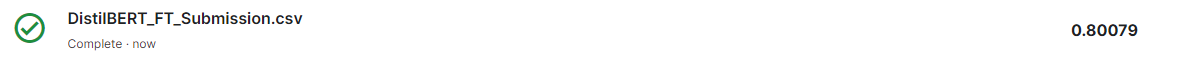

## Observations
Not bad! Note that we don't tune much this model, so probably we could improve it easily!

The important point is how easy is use hub models from huggingface and finetune. If you look the website, you can see that there are a lot of datasets and models made by de comunnity!

In the next notebook I will do my best combining all the stuff that we saw in this notebooks NLP series to get a better result. Also I will pre-process the data before feed it into the model
